In [73]:
import pandas as pd
import numpy as np
import os
from env import get_db_url
from pathlib import Path 
import csv
import wrangle as w

#from env import user, password, host

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.preprocessing

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer


In [47]:
train, validate, test = w.wrangle_zillow()

# 1. Apply the scalers we talked about in this lesson to your data and visualize the results for the unscaled and scaled distribution.

In [43]:
# creating copy of train df 
train_scaled = train.copy()

In [53]:
train.head()

,bedrooms,bathrooms,area,year_built,tax_value,taxamount,fips
10057,4.0,2.0,1561.0,1973.0,248240.0,2504.40,6059.0
2004969,3.0,2.0,1770.0,1960.0,88390.0,1671.93,6037.0
306031,2.0,1.0,1452.0,1946.0,81169.0,1310.88,6037.0
1038594,3.0,1.0,1000.0,1950.0,119174.0,1900.28,6037.0
270959,3.0,2.0,1974.0,1988.0,432268.0,5315.27,6037.0


# minmaxscaler

In [54]:
# make, fit for scaler, use:
columns_to_scale = ['bedrooms', 'bathrooms','tax_value','area']
scaler = MinMaxScaler()
# fit the object to my data:
train_scaled[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])

In [55]:
train.columns

Index(['bedrooms', 'bathrooms', 'area', 'year_built', 'tax_value', 'taxamount',
       'fips'],
      dtype='object')

In [57]:
train_scaled.head(2)

,bedrooms,bathrooms,area,year_built,tax_value,taxamount,fips
10057,0.666667,0.333333,0.457612,1973.0,0.261030,2504.40,6059.0
2004969,0.333333,0.333333,0.518921,1960.0,0.092929,1671.93,6037.0


Text(0, 0.5, 'Count')

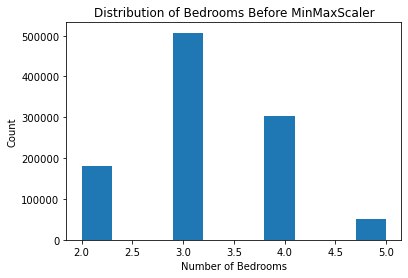

In [58]:
# before minmaxscaler applied
plt.hist(train.bedrooms)
plt.title('Distribution of Bedrooms Before MinMaxScaler')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

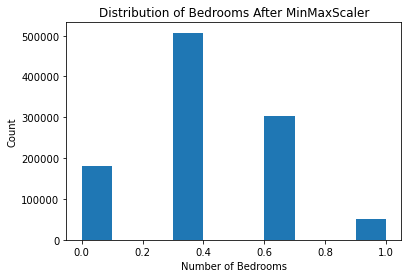

In [59]:
# visual of after MinMaxScaler applied
plt.hist(train_scaled.bedrooms)
plt.title('Distribution of Bedrooms After MinMaxScaler')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')

In [61]:
def visualize_scaler(scaler, df, columns_to_scale, bins=10):
    '''Function to create visuale of before and after scaling'''
    fig, axs = plt.subplots(len(columns_to_scale), 2, figsize=(16,9))
    df_scaled = df.copy()
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    for (ax1, ax2), col in zip(axs, columns_to_scale):
        ax1.hist(df[col], bins=bins)
        ax1.set(title=f'{col} before scaling', xlabel=col, ylabel='count')
        ax2.hist(df_scaled[col], bins=bins)
        ax2.set(title=f'{col} after scaling with {scaler.__class__.__name__}', xlabel=col, ylabel='count')
    plt.tight_layout()
#    return fig, axs

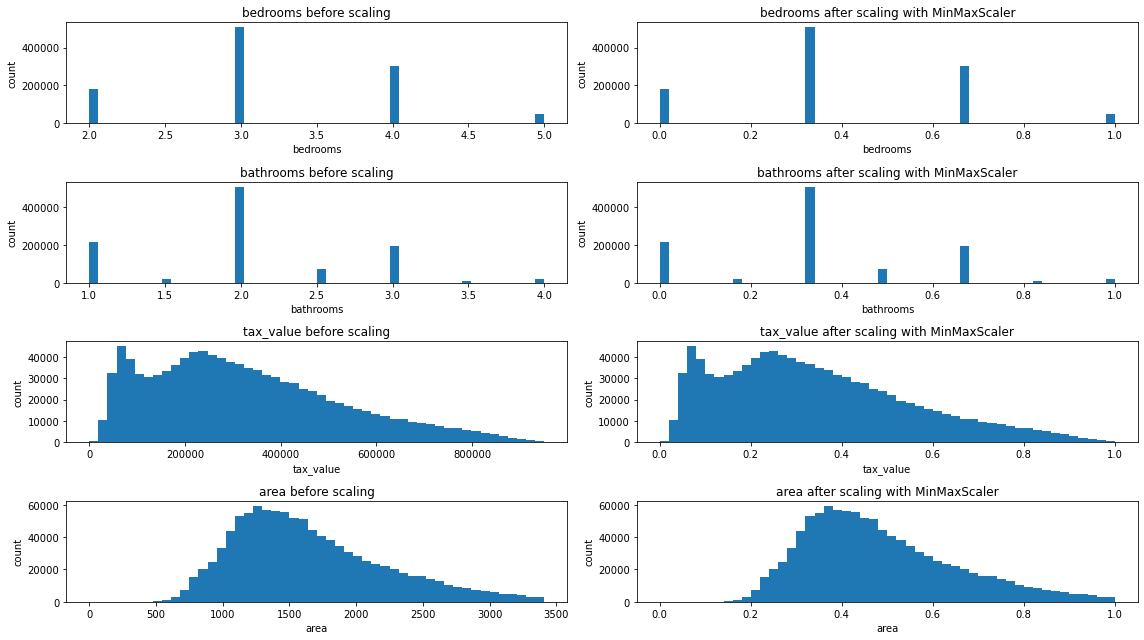

In [62]:
# MinMaxScaler Applied 
visualize_scaler(scaler=MinMaxScaler(),
                df=train,
                columns_to_scale=columns_to_scale,
                bins=50)

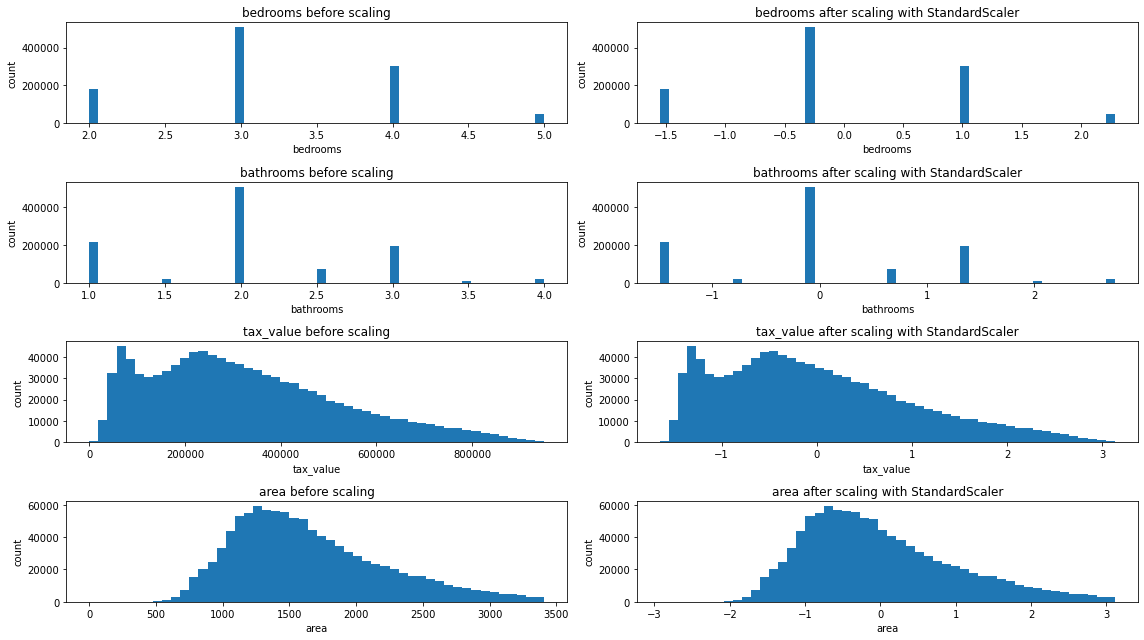

In [63]:
# StandardScaler Applied
visualize_scaler(scaler=StandardScaler(), df=train, columns_to_scale=columns_to_scale, bins=50)

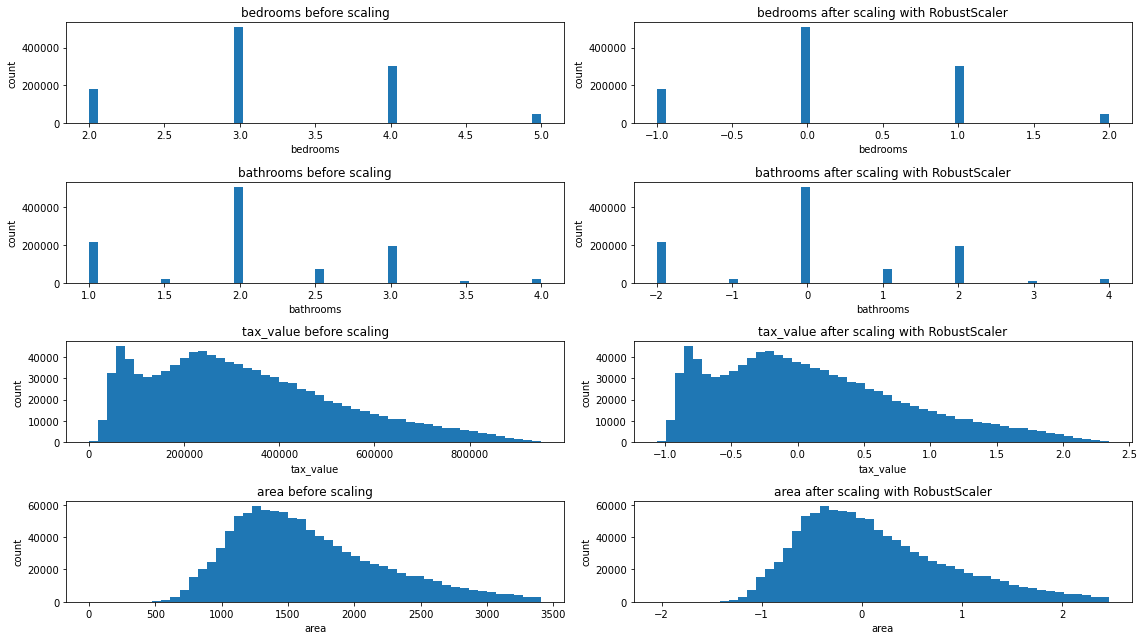

In [66]:
# RobustScaler Applied
visualize_scaler(scaler=RobustScaler(), df=train, columns_to_scale=columns_to_scale, bins=50)

## 2. Apply the .inverse_transform method to your scaled data. Is the resulting dataset the exact same as the original data?

In [68]:
scaler = MinMaxScaler()
original_data = train[['tax_value']]
scaled_data = scaler.fit_transform(original_data)

In [69]:
#scaled data view
scaled_data[:5]

array([[0.26102987],
       [0.09292915],
       [0.08533543],
       [0.12530208],
       [0.45455654]])

In [70]:
#original_data looks like 
original_data[:5]

,tax_value
10057,248240.0
2004969,88390.0
306031,81169.0
1038594,119174.0
270959,432268.0


In [71]:
#revert back to scaled data
scaler.inverse_transform(scaled_data)[:5]

array([[248240.],
       [ 88390.],
       [ 81169.],
       [119174.],
       [432268.]])

## 3. Read the documentation for sklearn's QuantileTransformer. Use normal for the output_distribution and apply this scaler to your data. Visualize the result of your data scaling.

### From sklearn.preprocessing.QuantileTransformer documentation:

This method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.

In [ ]:
### Good for using when you have outliers, this will help create a more normal distribution of data 

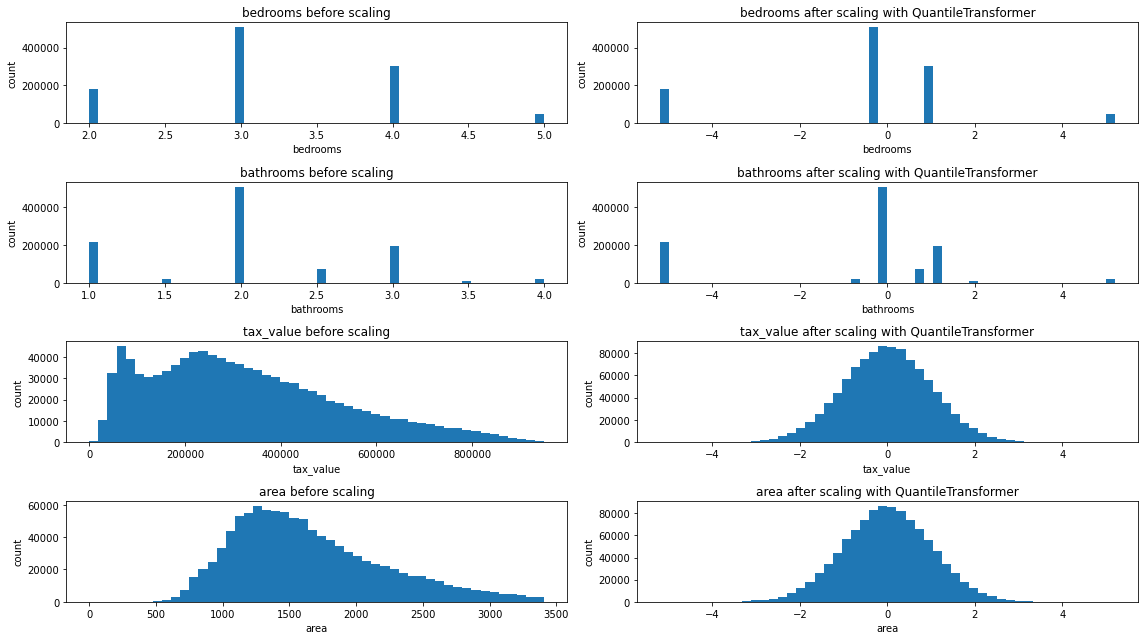

In [74]:
# QuantileTransformer Applied
visualize_scaler(scaler=QuantileTransformer(output_distribution='normal'), 
                 df=train,
                 columns_to_scale=columns_to_scale, 
                 bins=50)

### 4. Use the QuantileTransformer, but omit the output_distribution argument. Visualize your results. What do you notice?

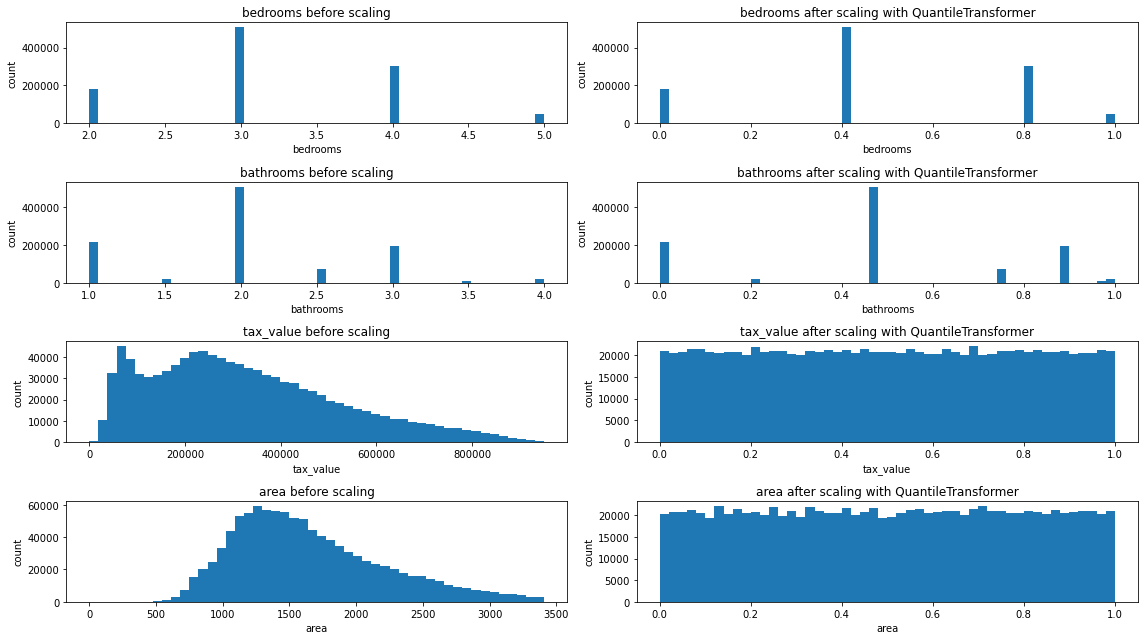

In [76]:
# if you don't use distribution out put it will make graph looks very bad and not normally distributed
# QuantileTransformer Applied
visualize_scaler(scaler=QuantileTransformer(), 
                 df=train, 
                 columns_to_scale=columns_to_scale, 
                 bins=50)

## Creating a Pipeline Function


In [81]:
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale=['bedrooms', 'bathrooms', 'tax_value', 'area'],
               return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    # make copies of our original data so we dont gronk up anything
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    #     make the thing
    scaler = MinMaxScaler()
    #     fit the thing
    scaler.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [82]:
scaler, train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, return_scaler=True)

In [85]:
scaler

MinMaxScaler()

In [86]:
train_scaled

,bedrooms,bathrooms,area,year_built,tax_value,taxamount,fips
10057,0.666667,0.333333,0.457612,1973.0,0.261030,2504.40,6059.0
2004969,0.333333,0.333333,0.518921,1960.0,0.092929,1671.93,6037.0
306031,0.000000,0.000000,0.425638,1946.0,0.085335,1310.88,6037.0
1038594,0.333333,0.000000,0.293048,1950.0,0.125302,1900.28,6037.0
270959,0.333333,0.333333,0.578762,1988.0,0.454557,5315.27,6037.0
...,...,...,...,...,...,...,...
991121,0.333333,0.000000,0.351423,1951.0,0.295330,3282.40,6111.0
1707758,0.666667,0.333333,0.545028,1961.0,0.099889,1463.61,6037.0
1770245,0.333333,0.666667,0.625110,1980.0,0.166626,2037.38,6037.0
1500740,0.000000,0.000000,0.228513,1955.0,0.501773,6509.69,6037.0


In [87]:
validate_scaled

,bedrooms,bathrooms,area,year_built,tax_value,taxamount,fips
1214918,0.333333,0.333333,0.506307,1964.0,0.077287,1147.78,6059.0
1799487,0.000000,0.000000,0.444412,1947.0,0.429376,4510.02,6037.0
1799139,0.333333,0.333333,0.454385,1947.0,0.231268,2684.01,6037.0
1099915,0.333333,0.333333,0.315048,1957.0,0.324493,3863.43,6037.0
1534222,0.333333,0.333333,0.453799,1949.0,0.191365,2359.42,6037.0
...,...,...,...,...,...,...,...
1471548,0.333333,0.000000,0.334702,1949.0,0.378232,4249.59,6037.0
1622461,0.000000,0.000000,0.217659,1949.0,0.066588,1160.00,6037.0
1242182,0.000000,0.000000,0.221473,1925.0,0.410197,4777.33,6037.0
179210,0.333333,0.333333,0.400997,1959.0,0.213934,2713.49,6037.0


In [88]:
test_scaled

,bedrooms,bathrooms,area,year_built,tax_value,taxamount,fips
443606,0.666667,0.666667,0.862716,1996.0,0.282531,4235.22,6037.0
1815876,0.000000,0.333333,0.539748,1948.0,0.063087,974.35,6037.0
1127428,0.000000,0.000000,0.262540,1923.0,0.293058,3455.76,6059.0
1328381,0.000000,0.333333,0.389557,1941.0,0.341700,4039.14,6037.0
674079,0.333333,0.000000,0.260194,1951.0,0.043045,818.99,6037.0
...,...,...,...,...,...,...,...
1758364,0.000000,0.000000,0.359636,1911.0,0.034329,475.00,6037.0
1176148,0.666667,0.333333,0.514520,1993.0,0.183441,3038.30,6037.0
671604,0.333333,0.333333,0.442065,NaN,0.482446,5566.22,6037.0
1009468,0.333333,0.333333,0.515400,1980.0,0.382481,4884.94,6059.0
